In [1]:
import csv
import cv2
import numpy as np
import sklearn
import time

In [2]:
_time = time.time()
lines = []
with open("data/driving_log.csv") as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)
print("lines",len(lines))#passed
print("_time ",(time.time() - _time))

lines 12041
_time  1.1787493228912354


In [18]:
less_lines = lines[0:12041]#try with 5% of data
print("lines",len(less_lines))#passed

lines 2000


In [19]:
_time = time.time()
from sklearn.model_selection import train_test_split
#train_samples, validation_samples = train_test_split(lines, test_size=0.2)#full data
train_samples, validation_samples = train_test_split(less_lines, test_size=0.2)

print("_time ",(time.time() - _time))

_time  0.001003265380859375


In [20]:
from sklearn.utils import shuffle
_time = time.time()
"""
images = []
measures = []
filename = ''
current_path = ''
for line in lines:
    for i in range(3):
        source_path = line[i]
        filename = source_path.split('\\')[-1]
        current_path = "data/IMG/"+filename
        image = cv2.imread(current_path)
        #image = cv2.imread(source_path)
        images.append(image)
        images.append(cv2.flip(image,1))
        measure = float(line[i+3])
        measures.append(measure)
        measures.append(measure*-1.0)
"""        
def generator(samples, batch_size=32):
    correction = 0.2
    num_samples = len(samples)
    while True: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            images = []
            angles = []
            for batch_sample in batch_samples:
                #for i in range(3):
                    ##source_path = line[i]##fulldata
                    source_path = line[0]##replace with line above
                    filename = source_path.split('\\')[-1]
                    current_path = "data/IMG/"+filename
                    image = cv2.imread(current_path)
                    image = cv2.resize(image, (0,0), fx=0.5, fy=0.5) 
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    images.append(image)
                    ##images.append(cv2.flip(image,1))
                    ##measure = float(line[i+3])##fulldata
                    measure = float(line[3])#replacewith line above
                    ##if(i == 1):#left vam
                    ##    measure = float(line[3]) + correction
                    ##elif(i == 2):#right cam
                    ##    measure = float(line[3]) - correction
                    angles.append(measure)
                    ##angles.append(measure*-1.0)

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            #yield sklearn.utils.shuffle(X_train, y_train)
            yield (X_train, y_train)

train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

#print("measures",len(measures))#passed
#print("measures ex:",measures[len(measures)-1])#passed
#print("images",len(images))#passed

print("_time ",(time.time() - _time))

_time  0.0009989738464355469


<generator object generator at 0x000001E7D33041A8>
<class 'tuple'>
32
label: 0.0


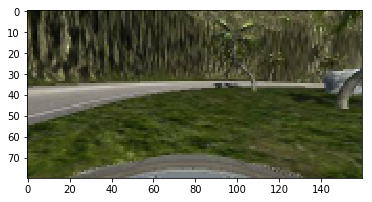

In [21]:
#making sure generator is fine

print(train_generator)
el_next = next(train_generator)
print(type(el_next))
print(len(el_next[0]))
print("label:",el_next[1][0])
#"""
#print(train_samples[0])
test_image = np.array(el_next[0][0])

import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline
#cv_rgb = cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB)
plt.imshow(test_image)
plt.show()
#"""

In [5]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, MaxPooling2D, Conv2D, Cropping2D

Using TensorFlow backend.


In [12]:
_time = time.time()
ch, row, col = 3, 80, 320  # Trimmed image format
#model :
model = Sequential()
#normalize and mean center
model.add(Lambda(lambda x: (x/255.0) - 0.5, input_shape=(160,320,3)))
model.add(Cropping2D(cropping=((75,25), (0,0)), input_shape=(160,320,3)))
#NVidia
model.add(Conv2D(24,(5,5), strides=(2,2), activation='relu'))
model.add(Conv2D(36,(5,5), strides=(2,2), activation='relu'))
model.add(Conv2D(48,(5,5), strides=(2,2), activation='relu'))
model.add(Conv2D(64,(3,3), strides=(2,2), activation='relu'))
model.add(Conv2D(64,(1,1), strides=(2,2), activation='relu'))
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))
print("_time ",(time.time() - _time))

_time  0.23575901985168457


In [ ]:
_time = time.time()
batch_size =32
#train
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
#hist = model.fit(X_train_test, y_train_test, validation_split=0.2, shuffle=True, epochs=10, verbose=1)
#hist = model.fit_generator(train_generator, samples_per_epoch=len(train_samples), validation_data=validation_generator, nb_val_samples=len(validation_samples), nb_epoch=10)
hist = model.fit_generator(train_generator, steps_per_epoch=len(train_samples)/batch_size, validation_data=validation_generator, validation_steps=len(validation_samples)/batch_size, epochs=5)
#hist = model.fit_generator(train_generator, steps_per_epoch=len(train_samples)/batch_size)
print("_time ",(time.time() - _time))


Epoch 1/5
301/301 [==============================] - 503s - loss: 0.0011 - acc: 0.3333 - val_loss: 6.0395e-16 - val_acc: 0.3333

In [31]:
print(hist.history)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

{'loss': [0.00013139776624253243, 1.5756124537906294e-15, 1.2260603399323175e-18, 2.0259967261086254e-19, 1.1223921429911286e-19, 7.180190395594424e-20, 5.3260669146417506e-20, 7.2144796088730626e-20, 7.814142710327171e-20, 5.2789288774433188e-20], 'acc': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'val_acc': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'val_loss': [4.8409559200867914e-14, 4.1976583055274935e-18, 4.6012252542080266e-19, 1.4037806879589817e-19, 6.1281953561978085e-20, 4.7204441366750869e-20, 5.1649157447811048e-21, 1.1527919888784015e-19, 3.0734722840020296e-20, 4.0569347792476004e-20]}


NameError: name 'plt' is not defined

In [30]:
#save
model.save('model_nvidia_1.h5')

In [54]:
#checkpoint--------------------------------------
#load
from keras.models import load_model
continue_model = load_model('model.h5')

In [55]:
continue_model.compile(loss='mse', optimizer='adam')
continue_model.fit(X_train_test, y_train_test, validation_split=0.2, shuffle=True, epochs=4, verbose=1)

Train on 9632 samples, validate on 2409 samples
Epoch 1/4
9632/9632 [==============================] - 17s - loss: 5.1179 - val_loss: 3.8942

In [56]:
del model